# Representace dat

Python před uživateli skrývá detaily datové representace. Když vytvoříte seznam, tak vám nabídne metody resp., kterými můžete získávat informace o seznamu (např. délku seznamu, nalezení prvku v seznamu), číst a zapisovat jeho prvky (indexace) resp. se seznamem manipulovat (přidávat či odebírat prvky), apod.  Vůbec vás nemusí jak je seznam representován v paměti.

To však je jen částečná pravda, neboť paměťová representace může výrazně ovlivnit efektivitu programu, tj. 
1. rychlost vykonávání programu
2. spotřebu operační paměti (tj. kolik paměti se pro uložení seznamu použije).

Pokud jsou seznamy malé, pak si ve většině případů nemusíme s efektivotou lámat hlavu. Je v zásadě jedno pokud operace trvá 1 µs nebo 1 ms (1000× vice, obojí je ale pro člověka nepostřehnutelně malý časový okamžik). Stejně je u osobních počítačů v zásadě jedno, zda seznam zaujme 1 KiB nebo 1 MiB (1024× více).

V okamžiku, kdy se začne pracovat s velkými daty (např. abonentů u celosvětových služeb, paketů v síti, nebo měření gigantické senzorové sítě) začíná být efektivita otázkou přežití. Pokud trvá přihlášení minutu, lze to ve většině situací tolerovat, pokud trvá 1000× déle (16 minut 40 vteřin), pak už vaši službu nikdo nevyužije. Podobný rozdíl pokud seznam zaujímá 200 MiB (a vejde se tak bez problémů do operační paměti) nebo 200 GiB (a vejde se tak jen stěží na vnější paměťové úložiště)

## Časová složitost

V případě časové náročnosti výpočtu lze pro jednoduchost vycházet z toho, že doba vykonání programu je funkcí velikosti seznamu.

Podívejme se například na následující program, který vytváří seznamy seznam náhodně promíchaných hodnot 0 až $n-1$ (každá hodnota je tam obsažena jen jednou).

In [44]:
from random import shuffle

def shuffled_range(n): # funkce vytvářející seznam
    rseq = list(range(n))
    shuffle(rseq)
    return rseq

# zjistíme čas a uložíme pro další zpracování
time_infos = []
ns = list(range(200_000,2_000_001, 200_000)) #seznam hodnot n, pro něž budeme měřit
for n in ns:
    print(n)
    t = %timeit -o shuffled_range(n) # měření rychlosti (výsledek se uloží do t)
    time_infos.append(t)

200000
141 ms ± 5.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
400000
302 ms ± 6.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
600000
463 ms ± 5.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
800000
637 ms ± 8.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1000000
803 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1200000
982 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1400000
1.17 s ± 8.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1600000
1.35 s ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1800000
1.53 s ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2000000
1.69 s ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Pomocí jupyterovského »magického«`%timeit` lze změřit čas provedení příslušného řádku (včetně relativně klíčové informace o směrodatné odchylce). Přepínač `o` zajistí, že se vrátí objekt, representující měření (a je pak uloženo do proměnné `t`).

Měření bylo provedeno pro seznamy s  délkou 200 000 a 2 milióny položek (včetně, proto je uvedena horní mez + 1) s krokem 200 000. 

In [45]:
# velikosti seznamů 

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np

def show_graph(x,y, polynomial_degree):
    # nastavení popisek
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(EngFormatter())

    plt.plot(x,y, "o") # graf závislosti (body)
    plt.grid(True)

    z = np.polyfit(x, y, polynomial_degree) # polynomiální
    p = np.poly1d(z) # vytváří funkci repr. lineární polynom
    plt.plot(x, p(x),"r--") # vykreslí trend
    print(p)

 
8.704e-07 x - 0.05154


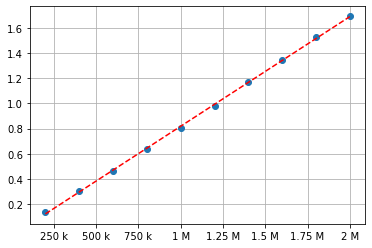

In [46]:
t = [info.average for info in time_infos] # zajímá nás jen  průměrný čas
show_graph(ns, t, 1)

Jak lze vidět z grafu, roste doba vykonávání lineárně a to rychlostí cca 0,9 sekundy na milion položek (hodnota závisí na rychlosti počítače). Abolutní člen, který by měl vyjadřovat konstantní režii (čas inicializace apod.) je větší seznamy zanedbatelný (v mém případě je z důvodů nepřesností dokonce záporný).

Pokud zanedbáme absolutní člen, pak je navíc zřejmé, že pokud se počet položek zdvojnásobí 
(např. z 500k na 1M) tak se zdvojnásobí i čas vykonávání (a zde ani nezávisí na směrnici).

Závislost mezi velikostí seznamu a dobou zpracovávání nemusí být jen lineární. Podívejme se například na elementární způsob řazení (třídění) tj. algoritmu, který seznam přeuspořádá, tak že jsou prvky umístěny od nejnižšího po nejvyšší (lze uvažovat i opačný směr). Algoritmus **řazení výběrem** vychází z jednoduché úvahy, že nejdříve najdeme nejmenší prvek ten vyměníme s prvním prvkem (pokud už není první), pak najdeme nejmenší prvek ve zbytkovém seznamu a prohodíme ho z druhým. Následuje nalezení nejmenšího prvku v podseznamu od třetího prvku, a tak pokračuje dál dokud se nesetříděný zbytek seznamu neomezí na jediný prvek.

In [55]:
def select_sort(s):
    for i in range(len(s)-1): # od jakého prvku hledáme minimum
        min_index = i
        for j in range(i, len(s)):
            if s[j] < s[min_index]:
                min_index = j
        s[i], s[min_index] = s[min_index], s[i]

In [59]:
s = shuffled_range(20) # promíchaná posloupnost čísel
print(s)  # pro jistotu vypíšeme (pravděpodobnost, že je setříděná je ale malá)
select_sort(s) # setřídíme
print(s) # vypíšeme setříděné

[9, 13, 15, 7, 0, 3, 16, 17, 10, 18, 6, 8, 19, 2, 11, 14, 5, 4, 12, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


>**Úkol**: Jaká je pravděpodobnost, že promíchaná posloupnost čísel je (náhodou) setříděná.

Pravděpodobnost je rovna pravděpodobnosti, že nastane jedna konkrétní permutace čísel mezi všemi možnými, jichž je $n!$ tj. $\frac{1}{n!}$. Pro $n = 20$ je to cca $4,11\cdot 10^{-19}$.

Pro zištění doby běhu použijeme opět magický příkaz `timeit`. Liší se jen rozsah hodnot a název volané metody.

In [69]:
time_infos2 = []
ns2 = list(range(2_000,10_001, 1_000)) #seznam hodnot n, pro něž budeme měřit
for n in ns2:
    print(n)
    s = shuffled_range(n)
    t = %timeit -o select_sort(s) # měření rychlosti (výsledek se uloží do t)
    time_infos2.append(t)

2000
138 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3000
303 ms ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4000
536 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5000
835 ms ± 6.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6000
1.2 s ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7000
1.64 s ± 8.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8000
2.16 s ± 24.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9000
2.82 s ± 89.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10000
3.78 s ± 220 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Pro zobrazení použijeme naší funkcí `show_graph`, které přidáme nově získaná pole `ns2` (počet položek řazeného pole) a `t2` (průněrný čas běhu). Nejdříve zvolíme lineární trend, jako v předchozím příkladě.

 
0.0004362 x - 1.127


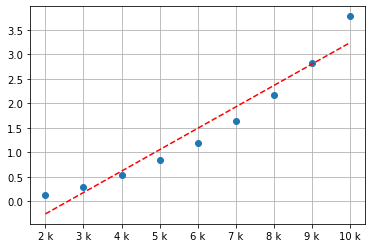

In [71]:
t2 = [info.average for info in time_infos2]
show_graph(ns2, t2, 1)

Je zřejmé, že lineární trend, příliš neodpovídá. Body vyjadřující čas provedení pro jednotlivá $n$ mají spíše tvar paraboly. Proto zkusíme trend stupně 2 (kvadratický).

           2
4.754e-08 x - 0.0001342 x + 0.2671


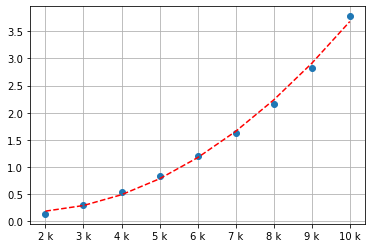

In [72]:
t2 = [info.average for info in time_infos2]
show_graph(ns2, t2, 2)

To už vypadá mnohem lépe. I v tomto případě je možné zenedbat absolutní člen a nyní i člen lineární. Čas provedení je pak řádově $4,75\cdot 10^{-8}n^2$. Nyní už je jasné proč jsme nezjišťovali čas pro $n = 200\,000 \ldots 2\,000\,000$. I pro nižší z těchto hodnot by to trvalo cca 1900 vteřin, je téměř 32 minut. Pro 2 milióny položek (což je desetkrát více) by to trvalo 10×10 déle tj. přes 52 hodin.

Jak lze tedy vidět, roste čas vykonávání promíchávání lineárně zatímco čas třídění kvadraticky. 

Tuto skutečnost, že matematicky vyjádřit tzv. asymptotické časové složitosti a pomocí Landauovy „O“ notace. Pokud funkce růstu můžeme od jistého (typicky velkého) čísla z obou stran omezit nějakými dvěma lineárními funkcemi, pak budeme tvrdit, že má lineární asymptotickou časovou složitost a budeme to značit $O(n)$ (čteno velké „o“ „en“). 

Podobně lze zavést i časovou složitost (slovo asymptotická se běžně vynechává) kvadratickou $O(n^2)$. 

To lze zobecnit na polynomy libovolného řádu. Pokud čas vykonávání roste nějakou polynomiální funkcí $a_n x^n + a_{n-1} x^{n-1} + \cdots + a_0$ je odpovídající časová složitost $O(x^n)$ (typicky se setkáváme běžně jen se složitostí kubickou.

Kromě polynomiální složitosti se v praxi setkáváme i s dalšími typy asymptotických složitostí.

| složitost     | označení      |
|---------------|---------------|
| $O(1)$        | konstantní    |
| $O(log(n))$   | logaritmická  |
| $O(n)$        | lineární      |
| $O(n\log(n))$ | loglineární   |
| $O(n^2)$      | kvadratická   |
| $O(n^3)$      | kubická       |
| $O(a^x)$      | exponenciální |

**Konstantní časovou složitost** mají operace, jejichž doba vykonávání nezáleží na počtu prvků kolekce. V případě seznamu mají tuto časovou složitost tři klíčové operace: zjištění délky seznamu, indexace (nalezení i-tého prvku) a přidávání prvku na konec seznamu.

>**Úkol**: Ověřte časovou složitost výše uvedených operací pomocí benchmarkingu.

Další typickou časovou složitostí u seznamů je ta **lineární**. Je spojena s operacemi, které přidávají či odebírají prvky uvnitř seznamu a které tudíž vyžadují posunutí prvků (musí se posunout všechny položky za vkládaným či vyjímaným, tj. průměrně $n/2$ prvků). Lineární časovou složitost má i vyhledávání, zda je nějaká hodnota obsažena v seznamu (operátor `in`) respektive na jaké pozici (metoda `index`). I zde je to jasné neboť je nutné projít buď všechny prvky (nejhorší případ), nebo alespoň půlku (průměrný případ).

>**Úkol**: Ověřte časovou složitost operací s lineární složitostí, Vytvářejte promíchané seznamy čísel a pak:
>1. hledejte náhodný prvek, který se v nich nachází
>2. hledejte prvek, který se v nich nenachází
>3. vyjímejte prvek v náhodné pozici (příkaz `del`)
>4. vyjímejte náhodný prvek podle jeho hodnoty (tj. nějaké číslo, které se v seznamu určitě nachází)
>5. vkládejte prvek na náhodnou pozici (kamkoliv v seznamu)

**Kvadratickou časovou složitost** nemá žádná ze standardních operací nad seznamem (ani řazení `sort` viz níže), může se však vyskytnout v případě, že se provede průměrně $n$ operací s lineární složitostí.

Příkladem budiž například výmaz určitých položek seznamu, kde je počet odstraněných položek proporcionální k velikosti seznamu (tj. například je proveden výmaz cca poloviny položek).

In [9]:
from random import normalvariate
def random_list(n, μ, σ): 
    # pomocná metoda pro generování seznamu s náhodným obsahem
    return [normalvariate(μ, σ) for _ in range(n)]

def remove_outliers(lst, min, max):
    for i in reversed(range(len(lst))):
        if not (min <= lst[i] <= max):
            del lst[i]
            
s = random_list(10, 0, 1)
print(s)
remove_outliers(s, -1.0, 1.0) # z teorie je zřejmé že bude vymazána cca třetina položek
print(s)
print(len(s))

[1.3076182847500615, -0.19455352971772377, 1.3238986795848862, 1.0930187324504679, 0.03098734857896747, 0.32516505339826896, 1.4670071132597895, -0.6582798382195861, -0.10529423804465683, -0.48349124646366154]
[-0.19455352971772377, 0.03098734857896747, 0.32516505339826896, -0.6582798382195861, -0.10529423804465683, -0.48349124646366154]
6


První pomocná funkce generuje seznam, jenž obsahuje náhodná čísla z normálního rozdělení s požadovanou střední hodnotou a směrodatnou odchylkou. Tato funkce má časovou složitost $O(n)$ neboť přidává $n$ s časovou složitostí $O(1)$.

Hlavní funkce, pak ze seznamu odebírá prvky, které neleží v intervalu $[min, max]$. což se typicky používá pro tzv. odlehlé body (*outliers*). Funkce prochází (pozpátku!) seznam a pomocí příkazu `del` vymazává prvky. Pro algoritmus je klíčové, že prvky jsou odmazávány v opačném směru, neboť dopředný algoritmus posouvá indexy ještě nezkontrolovaných prvků. 

>**Úkol**: Navrhněte algoritmus, který dané prvky odstraní s lineární časovou složitostí.

Stačí prvky, které mají zůstat, kopírovat do jiného seznamu. Původní seznam může být následně odstraněn z paměti. Lze to udělat i pomocí seznamové komprehenze.

In [10]:
[p for p in random_list(10, 0, 1) if -1 <= p <= 1]

[0.030537618343014095,
 -0.6595644000080445,
 0.5814670660086998,
 -0.38763018363506624,
 0.8912492207664056]

>**Otázka**: Jaká je časová složitost spojení obou kroků tj. generování náhodného seznamu a následné odstranění prvků výmazem.

Pokud známe časovou složitost jednotlivých postupných kroků, pak je výsledná časová složitost rovna největší (= v limitě nejrychleji rostoucí) časové složitosti. V našem případě máme lineární a kvadratickou časovou složitost. Výsledná časová složitost, je rovna kavdratické tj. platí $O(n)+O(n^2) = O(n^2)$.

**Logaritmická časová složitost** je typická pro některé algoritmy vyhledávání. Ve standardním rozhraní seznamu však není zastoupena. Klasickým příkladem je binární vyhledávání (https://en.wikipedia.org/wiki/Binary_search_algorithm). V Pythonu je implementována v modulu `bisect`.

Binární vyhledávání funguje jen na seřazených posloupnostech. Klíčovým úkolem je proto  zajistit, že je posloupnost udržována seřazená (). To lze zajistit dvěma způsoby:
1. nové položky jsou vkládány na správná místa tzv. vřazování (každé vkládání má složitost $O(n)$, neboť se obecně vkládá i dovnitř seznamu, pokud je vstup už seřazen ve správném směru, pak se je ale časová složitost konstantní!)
2. pole je před vyhledáváním seřazeno (to však má u běžně používaných algoritmů časovou složitost $O(n\log(n))$)

Celková složitost vyhledávání je tak dána vzorem vkládání a hledání.
1. pokud se více vkládá než hledá resp. průběžně vkládání průběžně střídá s vkládáním a jeho podíl není zanedbatelný, tak výrazně převažuje režie vkládání a jediným alespoń trochu akceptovatelným algoritmem je vřazování (vkládá se $n$ položek s časovou složitostí $O(n)$ tj, celková složitost vkládání je $O(n^2)$), vyhledávání lze zanedbat. To však platí jen v případě, že máme k dispozici jen seznam.  Použití slovníku vede téměř vždy k mnohem lepšímu výsledku (viz níže).
2. hodnoty se nejdříve najednou vloží, a pak se nad nimi masivně vyhledává (počet vyhledávání je řádově větší než počet prvků). Příkladem jsou například jízdní řády. Zde se vyplatí po vložení seznam, setřídit a pak využívat binární vyhledávání (hlavně tehdy, když je seznam extrémně rozsáhlý). Celková složitost je $O(n \log(n))$
3. Výrazně převažují vyhledávání, do seznamu se však občas vkládají nové položky. Příkladem je seznam uživatelů nějaké webové služby. Uživatelé se často vyhledávají, ale jen občas přibývají noví. Zde je nejvhodnější strategií vřazování. Časová složitost je dáná opět primárně vyhledáváním ($O(n \log(n))$).

>**Úkol:** Pomocí modulu `bisect` implementujte vřazování a binární vyhledávání (modul nabízí zbytečně složité i když obecně použitelné funkce, implementace vřazování a vyhledávání je však uvedena na konci dokumentace). Následně porovnejte s efektivitou množiny (`set` viz níže).

**Loglineární časová složitost** $O(n\log(n))$ je další typickou složitostí. Tuto složitost mají především všechny běžně používané univerzální řadící (třídící) algoritmy, a to včetně třídícího algoritmu užívaného v Pythonu (univerzální = použitelné na libovolný datový typ s definicí uspořádání). Python aktuálně používá nepříliš známý a dosti komplexní algoritmus *Timsort* (https://en.wikipedia.org/wiki/Timsort), který má v průměrném případě (tj. například pro náhodně promíchané) prvky složitost loglineární. Pokud je však vstup alespoň částečně seřazen, může dosahovat i lineární časovou složitost.

Posledním běžným typem časové složitosti nad kolekcemi je **exponenciální časová složitost**, kde čas roste podle křivky ($a^n$) kde $a>1$ (ostatní členy lze s klidem zanedbat). Základní charakteristikou této časové složitosti, je to že čas roste s každám dalším $a$ násobně. $a$ je v praxi relativně malé číslo (ale vždy větší než 1!), takže růst je zpočátku pomalý, ale již v řádu malých desítek rychle čas provedení rychle roste (vteřiny, minuty), pro vyšší desítky se už výpočet nedá provádět v reálném čase (tj. v řádu hodin či dnů). Pro velikosti v řádu stovek už nemusí stačit ani očekávaný věk sluneční soustavy.

Exponenciální časová složitost je typická pro algoritmy, které procházejí všechny kombinace prvků (resp. jejich $k$-procentní část). V mnoha případech existují sofistikovanější algoritmy, které úlohu řeší v polynomiálním čase (tj. $O(n^k)$). Existují však i algoritmy, kde není takové řešení známo, resp. je vysoce pravděpodobné (i když nikoliv dokázané), že neexistuje (tzv. https://cs.wikipedia.org/wiki/NP-%C3%BAplnost). Nejznámější z těchto úloh je problém obchodního cestujícího a problém batohu.

V těchto případech se musíme spokojit s optimalizací exponenciálního růstu (tj. nižším $a$, které umožňuje aplikovat je i na o něco delší seznamy). Například pokud řešíme problém obchodního cestujícího hrubou silou tak jsme omezeni skutečně jen na malé desítky, optimalizovaný algoritmus pokrývá i malé stovky). Další možností je vyhledání  řešení, které není optimální a ale dostatečně s k němu blíží (viz například feromonový algoritmus pro řešení problému obchodního cestujícího).

### Obecné závěry o časové složitosti pro začátečníky

Časovou složitost některých algoritmů lze určit aplikací dvou pravidel:
* algoritmus využívající $m$ vnořených cyklů, z nichž každý iteruje  $k * n$-krát, kde $k > 0$ nebo do hodnoty $k * i$-krát, kde $i$ je hodnota nadřízeného cyklu má složitost $O(n^k)$
* pokud je v algoritmu více lineárních kroků, pak je celková časová složitost dána krokem s limitně nejvyšší složitostí.

U některých algoritmů je však určení časové složitosti náročnější a u určité části je to vyšší matematika (a programátor se tak musí spokojit s výsledky matematiků).

Další komplikace přinášejí algoritmy, jejichž časová složitost závisí na uspořádání dat v kolekci (resp. na vstupu). V tomto případě se nejčastěji uvádí tzv. **průměrná složitost**, kterou si lze představit jako časovou složitost, která převažuje u většiny možných vstupů. Typicky je to složitost nad náhodným obsahem. Existuje však i **složitost v nejlepším případě** (kdy je vstup uspořádán tak, že algoritmus funguje nejefektivněji), a **složitost v případě nejhorším**. 

Zřejmé je to například u vyhledávání. Pokud je hledaný prvek vždy na prvním místě a jen výjimečně na posledním, pak je časová složitost triviálního algoritmu konstantní. Je-li naopak vždy na konci je časová složitost shodná s průměrným případem (i když je v průměru čas hledání dvojnásobný!). U řadících algoritmů je problém podobný, jen je často mnohem obtížnější definovat vstupy vedoucí k nejlepší či nejhorší časové složitosti. U některých algoritmů s běžnou časovou složitostí $O(n\log(n))$ mohou nevhodná data vést ke složitosti $O(n^2)$. To může vést k tomu, že výpočet trvající zlomky vteřin bude trvat celé minuty či hodiny.

V praxi je nutno zohlednit skutečnost, že klíčová bývá časová složitost v nejhorším případě, neboť častým požadavkem bývá maximální doba odezvy.  Navíc pravděpodobnost případů s nejhorší časovou složitostí může být více, než by vyplývalo z rovnoměrného rozložení.

* speciální rozložení jous častější z důvodu potenciálního předzpracování. Relativně častá jsou částečně uspořádaná vstupní data, která u některých řadících algoritmů vedou k lineární složitosti (`Timsort`), u jiných naopak ke kvadratické (`Quicksort`).
* podíl *nevhodných* dat může změnit útočník (posíláním *nevhodně* uspořádaných dat může vést ke zvýšení doby odezvy, tj. je to přípklad DOS útoku).

Hlavním důvodem, proč je nutné znát časové složitosti, je odhad použitelnosti algoritmů s ohledem na velikost zpracovávaných dat. Z tohoto hlediska lze časové složitosti rozdělit do čtyř kategorií.

**operace je i pro velká dat provedena téměř okamžitě**  (konstatní a logaritmická). hlavím problémem je tak spíše nalezení dostatečně velkého a dostatečně rychlého úložiště (tj. kritické jsou přístupové časy k paměti, případné swapování)
**operace jsou netolerovatelně pomalé jen pro řád stovek miliónu, či spíše ještě větší** (lineární, loglineární), což lze u některých typů dat vyloučit (například počet zaměstananců jen stěží překoná hranici stovek miliónů)
**operace, jejichž nasazení je nutno zvažovat již na hranici tisíců či desetitisíců** (kvadratické a kubické), zde už je časová složitost faktorem, který nejvíce ovlivňuje nasazení. Lze počítat 
**exponenciální časová složitost** je akceptovatelná jen pokud je počet prvků malý a striktně omezen.

Při hodnocení algoritmů jsou kromě prosté časové složitosti důležité i další apekty, které se ve formalismu časové apekty zanedbávají.
* nižší členy polynomu vyjadřujícího časovou závislost především konstantní člen = může výrazně ovlivnit efektivitu především u malých kolekcí (řádově do malých stovek)
* násobící koeficient = může výrazně ovlivnit využitelnost a to i pro velká data, vyšší koeficient znamená, že algoritmus je vždy pomalejší než jiné se stejnou složitostí ale jiným násobitelem) a i pro velká data dokonce může být pomalejší než algoritmus s nižší časovou složitostí.

Jako případovou problémů s interpretací časové složitosti lze uvést již dříve zmíněný vestavěný algoritmus třídění.

### Problémy se zjištěním a interpretací časové složitosti

Budeme měřit rychlost setřídění náhodně promíchaného seznamu, tj. pokusíme se odhadnbout průměrnou časovou složitost.

Nyní však nezvolíme aritmetickou posloupnost postupně rostoucích hodnot $n$ ale posloupnost geometrickou, s hodnotami $2^{15}, 2^{16}, 2^{17}, \ldots, 2^{24}$

In [10]:
time_infos3 = []
ns3 = [2**n for n in  range(15,25)] #seznam hodnot n, pro něž budeme měřit
for n in ns3:
    print(n)
    s = shuffled_range(n)
    t = %timeit -o s.sort() # měření rychlosti (výsledek se uloží do t)
    time_infos3.append(t)

32768
168 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
65536
345 µs ± 5.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
131072
692 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
262144
1.72 ms ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
524288
3.63 ms ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1048576
7.35 ms ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2097152
14.8 ms ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
4194304
29.1 ms ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
8388608
58.4 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
16777216
117 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 
6.999e-09 x - 9.823e-05


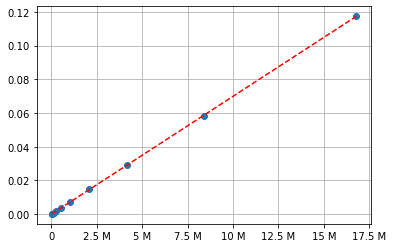

In [12]:
t3 = [info.average for info in time_infos3]
show_graph(ns3, t3, 1)

Závislost se na první pohled jeví jako lineární. Navíc násobitel je velmi nízký (7 miliardtin). Tj. i pole o velikosti stomiliónů položek (zaujímající paměť v řádu GiB) se setřídí za méně než sekundu. Python je obecně dost pomalý jazyk, ale třídění je implementováno v nízkoúrovňovém jazyce a je ručně optimalizováno pro třídění běžných hodnot včetně využití `insertion sort` pro malé seznamy (to mimo jiné znamená, že nemá prakticky smysl používat jiný algoritmus, především pak algoritmus napsaný v Pythonu a to ani pro malé seznamy).

Podle dokumentace je však složitost třídění $O(n \log(n)$ a i teorie tvrdí, že neexistuje žádný univerzální třídící algoritmus s lepší časovou složitostí. Proto se pokusíme nalézt odpovídající funkci (je třeba využít jinou funkci z balíku `scipy`).

In [23]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, a): # funkce parametrizovaná parametrem `a`
    return a * x * np.log(x)

par, _ = curve_fit(func, ns3, t3) 
# najde takové `a`, že součet druhých mocnin odchylek je minimální
print(par)

[4.25816254e-10]


Seznam obsahuje optimální hodnoty parametrů v pořadí jak jsou uvedeny ve funkci (v našem případě je jen jeden parametr `a` a je tedy roven cca 4.26e-10).
Nyní zakreslíme jak lineární tak loglineární trend a pro porovnání i trend operace pro promíchávání hodnot, jenž je také lineární.

Pro zobrazení většího rozsahu hodnot využijeme logaritmickou škálu jak na ose $x$ (se základem 2), tak na osy $y$ (se základem 10$).

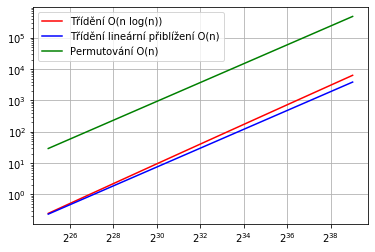

In [57]:
x = np.fromiter((2**i for i in range(25,40)), dtype=np.float64)
fig, ax = plt.subplots() # získání objektu representujícího graf s osami
ax.set_xscale('log', basex=2) # logaritmická `x`
ax.set_yscale('log') # logaritmická `y` 
plt.grid(True)
plt.plot(x, func(x, *par), "r", label="Třídění O(n log(n))")
plt.plot(x, 6.999e-9*x, "b",label="Třídění lineární přiblížení O(n)")
plt.plot(x, 8.704e-07*x, "g", label="Permutování O(n)")
plt.legend()


Graf ukazuje, že algoritmus vykazuje jisté zpomalení, ale ani v řádu $2^40$, kdy pole vyžaduje paměti v řádu jednotek terabytů (TiB), není rozdíl příliš patrný (obě hodnoty jsou v řádu deseti tisíců vteřin tj. cca hodin a očekávaná doba provedení je 2-3× větší). Navíc i tak je vestavěné řazení výrazně pomalejší než vestavěné promíchávání 